In [1]:
#%matplotlib notebook
%matplotlib widget

import ComunicationClasses.Database_collector

import matplotlib.pyplot as plt

import pandas as pd

from math import pi
from numpy import array
from scipy.optimize import minimize
from DataAnalysisClasses.SensorCurve3D import SensorCurve3D
from DataAnalysisClasses.AngleCalculator import AngleCalculator
from DataAnalysisClasses.KalmanFilter import KalmanFilter
from DataAnalysisClasses.BiasCompensator import BiasCompensator
from ComunicationClasses.Database_collector import Database_collector
from DataAnalysisClasses.GeometryConstants import GeometryVectors

plt.ion()

# Get IMU data from database

## Create DB client and test connection

In [2]:
print('Testing connection')
db_host_address = 'localhost'
print('Server IP: ' + db_host_address)
db_client = Database_collector(host=db_host_address)
if not db_client.check_connection():
    raise RuntimeError('No dataframe connection')
else:
    print('Connection ok')

Testing connection
Server IP: localhost
Connection ok


In [3]:
print('List of databases:')
print(db_client.get_db_list())

print('List of measurements:')
print(db_client.get_measurements_list('scan_sensor_test'))

List of databases:
['_internal', 'scan_sensor_test']
List of measurements:
['ISM_330_raw', 'MPU_9255_raw', 'scanner_raw']


### Get raw data from inertial sensors

In [4]:
#time_start=1644518082462
#time_stop = 1644518106858
time_start=1652530355581
time_stop = 1652530381703
data_raw_ISM = db_client.get_measurement_data('scan_sensor_test', 'ISM_330_raw', time_start, time_stop).dropna()
data_raw_MPU = db_client.get_measurement_data('scan_sensor_test', 'MPU_9255_raw', time_start, time_stop).dropna()

### Compensate initial bias

In [5]:
bias_ISM = BiasCompensator('ISM_330', 'linear')
bias_MPU = BiasCompensator('MPU_9255', 'linear')
# Use first seconds to get gyro bias|
bias_ISM.set_gyro_const_bias(2000, data_raw_ISM)
bias_MPU.set_gyro_const_bias(2000, data_raw_MPU)

In [6]:
# Apply bias compensation
data_bias_ISM = bias_ISM.apply_bias(data_raw_ISM)
data_bias_MPU = bias_MPU.apply_bias(data_raw_MPU)

### Rotate vectors of IMU data

In [7]:
device_geometry = GeometryVectors()
data_rot_ISM = device_geometry.rotation_apply_vect(data_bias_ISM,['mean_acc_X_b','mean_acc_Y_b','mean_acc_Z_b'],'ISM_330')
data_rot_ISM = device_geometry.rotation_apply_vect(data_rot_ISM,['mean_gyro_X_b','mean_gyro_Y_b','mean_gyro_Z_b'],'ISM_330')
data_rot_MPU = device_geometry.rotation_apply_vect(data_bias_MPU,['mean_acc_X_b','mean_acc_Y_b','mean_acc_Z_b'],'MPU_9255')
data_rot_MPU = device_geometry.rotation_apply_vect(data_rot_MPU,['mean_gyro_X_b','mean_gyro_Y_b','mean_gyro_Z_b'],'MPU_9255')
# drop unneded columns
data_rot_ISM.drop(columns=['mean_acc_X','mean_acc_Y','mean_acc_Z','mean_gyro_X','mean_gyro_Y','mean_gyro_Z'], inplace=True)
data_rot_MPU.drop(columns=['mean_acc_X','mean_acc_Y','mean_acc_Z','mean_gyro_X','mean_gyro_Y','mean_gyro_Z'], inplace=True)

print(data_rot_ISM.describe())

print(data_bias_ISM.describe())

print(data_rot_MPU.describe())

print(data_bias_MPU.describe())

### Show two sensors data against each other

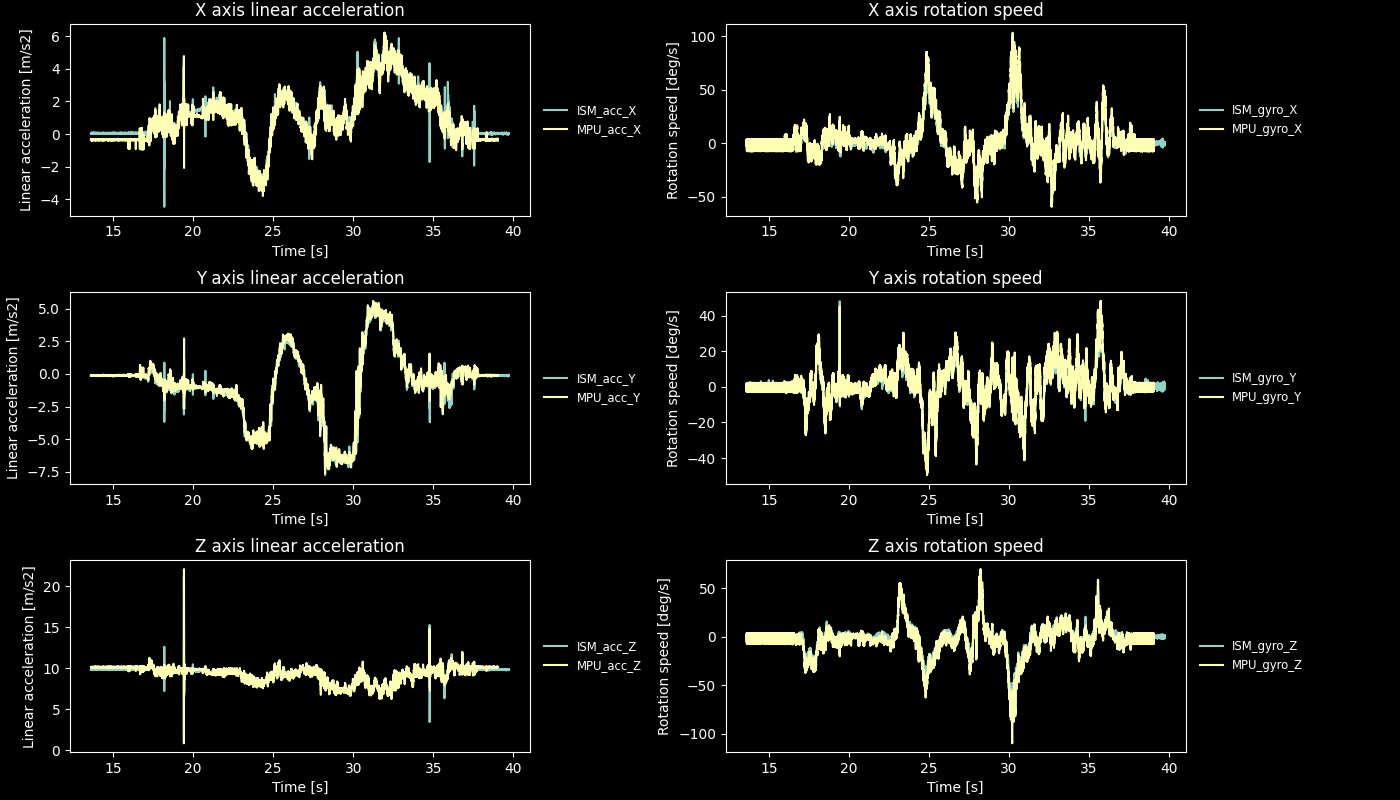

In [8]:
# Use dark theme for plots
plt.style.use('dark_background')

# Set up plot figure (canvas)
figure, axis = plt.subplots(3, 4,figsize=(14,8),gridspec_kw={'width_ratios': [2.6, 1,2.6,1]})

# First plot
axis[0, 0].plot(data_rot_ISM['mean_time_rel'], data_rot_ISM['mean_acc_X_b'], label='ISM_acc_X')
axis[0, 0].plot(data_rot_MPU['mean_time_rel'], data_rot_MPU['mean_acc_X_b'], label='MPU_acc_X')
axis[0, 0].set_title('X axis linear acceleration')
axis[0, 0].set_xlabel('Time [s]')
axis[0, 0].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_0_0,l_0_0 = axis[0,0].get_legend_handles_labels()
axis[0,1].legend(h_0_0,l_0_0,borderaxespad=0, mode='expand', loc='center', fontsize='small',frameon=False)
axis[0,1].axis("tight")
axis[0,1].axis("off")


# Second plot
axis[0, 2].plot(data_rot_ISM['mean_time_rel'], data_rot_ISM['mean_gyro_X_b'], label='ISM_gyro_X')
axis[0, 2].plot(data_rot_MPU['mean_time_rel'], data_rot_MPU['mean_gyro_X_b'], label='MPU_gyro_X')
axis[0, 2].set_title('X axis rotation speed')
axis[0, 2].set_xlabel('Time [s]')
axis[0, 2].set_ylabel('Rotation speed [deg/s]')
# Set legend next to plot
h_0_2,l_0_2 = axis[0,2].get_legend_handles_labels()
axis[0,3].legend(h_0_2,l_0_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[0,3].axis("tight")
axis[0,3].axis("off")


# Third plot 
axis[1, 0].plot(data_rot_ISM['mean_time_rel'], data_rot_ISM['mean_acc_Y_b'], label='ISM_acc_Y')
axis[1, 0].plot(data_rot_MPU['mean_time_rel'], data_rot_MPU['mean_acc_Y_b'], label='MPU_acc_Y')
axis[1, 0].set_title('Y axis linear acceleration')
axis[1, 0].set_xlabel('Time [s]')
axis[1, 0].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_1_0,l_1_0 = axis[1,0].get_legend_handles_labels()
axis[1,1].legend(h_1_0,l_1_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,1].axis("tight")
axis[1,1].axis("off")


# Fourth plot
axis[1, 2].plot(data_rot_ISM['mean_time_rel'], data_rot_ISM['mean_gyro_Y_b'], label='ISM_gyro_Y')
axis[1, 2].plot(data_rot_MPU['mean_time_rel'], data_rot_MPU['mean_gyro_Y_b'], label='MPU_gyro_Y')
axis[1, 2].set_title('Y axis rotation speed')
axis[1, 2].set_xlabel('Time [s]')
axis[1, 2].set_ylabel('Rotation speed [deg/s]')
# Set legend next to plot
h_1_2,l_1_2 = axis[1,2].get_legend_handles_labels()
axis[1,3].legend(h_1_2,l_1_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,3].axis("tight")
axis[1,3].axis("off")


#Fifth plot
axis[2, 0].plot(data_rot_ISM['mean_time_rel'], data_rot_ISM['mean_acc_Z_b'], label='ISM_acc_Z')
axis[2, 0].plot(data_rot_MPU['mean_time_rel'], data_rot_MPU['mean_acc_Z_b'], label='MPU_acc_Z')
axis[2, 0].set_title('Z axis linear acceleration')
axis[2, 0].set_xlabel('Time [s]')
axis[2, 0].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_2_0,l_2_0 = axis[2,0].get_legend_handles_labels()
axis[2,1].legend(h_2_0,l_2_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,1].axis("tight")
axis[2,1].axis("off")


# Sixth plot
axis[2, 2].plot(data_rot_ISM['mean_time_rel'], data_rot_ISM['mean_gyro_Z_b'], label='ISM_gyro_Z')
axis[2, 2].plot(data_rot_MPU['mean_time_rel'], data_rot_MPU['mean_gyro_Z_b'], label='MPU_gyro_Z')
axis[2, 2].set_title('Z axis rotation speed')
axis[2, 2].set_xlabel('Time [s]')
axis[2, 2].set_ylabel('Rotation speed [deg/s]')
# Set legend next to plot
h_2_2,l_2_2 = axis[2,2].get_legend_handles_labels()
axis[2,3].legend(h_2_2,l_2_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,3].axis("tight")
axis[2,3].axis("off")

figure.subplots_adjust(left=0.05,
                    bottom=0.06, 
                    right=0.98, 
                    top=0.97, 
                    wspace=0.03, 
                    hspace=0.4)
#plt.subplot_tool()
#figure.tight_layout(pad=0.1, w_pad=0, h_pad=0.01)

### Calculate acceleration vector in new point (holding only translated data)

In [9]:
# Calculate angular speed derivative from 3 consecutive samples

def derivative(df_in,column_name):
    df_temp = df_in[[column_name]].rolling(window=301, center=True, win_type="gaussian").mean(std=60)
    df_temp['prev'] = df_temp[column_name].shift(1)
    df_temp['next'] = df_temp[column_name].shift(-1)
    #df_temp['prev'] = df_in[column_name].shift(1)
    #df_temp['next'] = df_in[column_name].shift(-1)
    #print(df_temp.head())
    df_in[column_name+'_der']=((df_temp['next']-df_temp['prev'])/2)*1000
    
derivative(data_rot_ISM,'mean_gyro_X_b')
derivative(data_rot_ISM,'mean_gyro_Y_b')
derivative(data_rot_ISM,'mean_gyro_Z_b')
derivative(data_rot_MPU,'mean_gyro_X_b')
derivative(data_rot_MPU,'mean_gyro_Y_b')
derivative(data_rot_MPU,'mean_gyro_Z_b')

data_rot_ISM.fillna(0.0, inplace=True)
data_rot_MPU.fillna(0.0, inplace=True)
#print(data_rot_ISM.head())
#data_rot_ISM['mean_acc_Z_b'].rolling(window=3, center = True).apply(moving_derivative, raw=True)
#data_rot_MPU.rolling(window=3).apply(mad, raw=True)

In [10]:
data_rot_ISM.to_csv('ism_test.csv')

### Show derivative lowpass filter frame

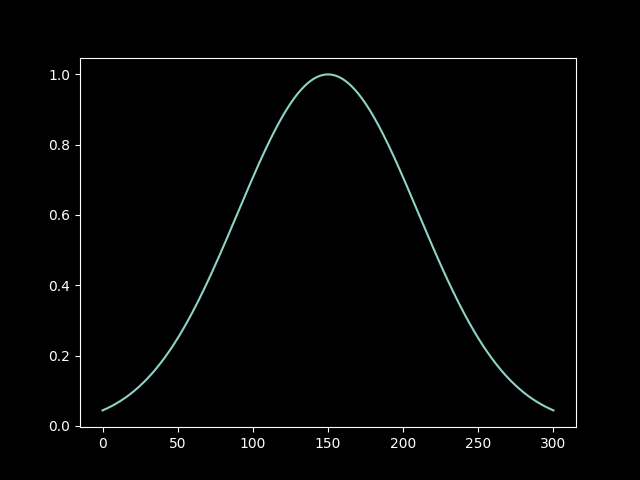

In [11]:
from scipy import signal
window = signal.windows.gaussian(301, std=60)
ax1 = plt.figure().add_subplot()
ax1.plot(window)

### Show rotation speed derivatives

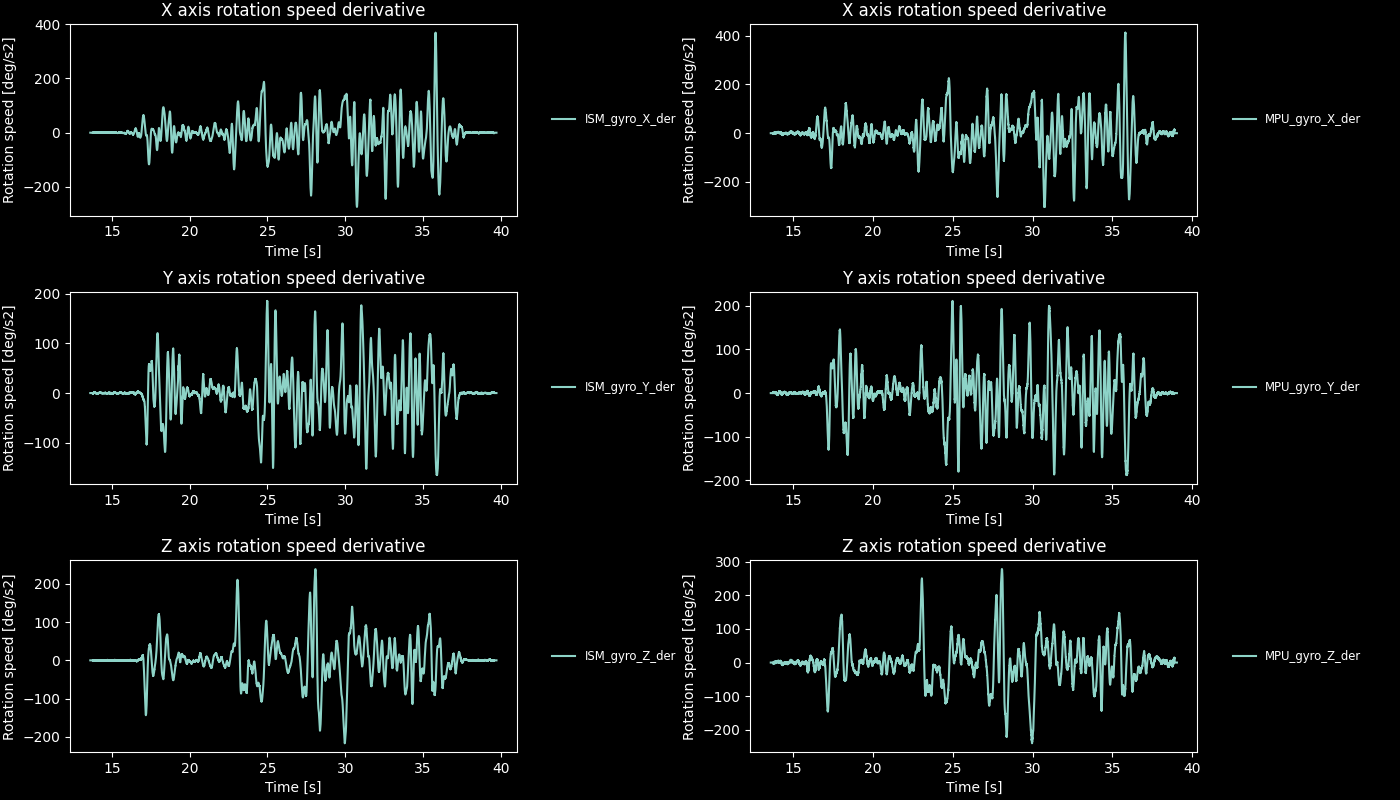

In [12]:
# Use dark theme for plots
plt.style.use('dark_background')

# Set up plot figure (canvas)
figure, axis = plt.subplots(3, 4,figsize=(14,8),gridspec_kw={'width_ratios': [2.6, 1,2.6,1]})

# First plot
axis[0, 0].plot(data_rot_ISM['mean_time_rel'], data_rot_ISM['mean_gyro_X_b_der'], label='ISM_gyro_X_der')
axis[0, 0].set_title('X axis rotation speed derivative')
axis[0, 0].set_xlabel('Time [s]')
axis[0, 0].set_ylabel('Rotation speed [deg/s2]')
# Set legend next to plot
h_0_0,l_0_0 = axis[0,0].get_legend_handles_labels()
axis[0,1].legend(h_0_0,l_0_0,borderaxespad=0, mode='expand', loc='center', fontsize='small',frameon=False)
axis[0,1].axis("tight")
axis[0,1].axis("off")


# Second plot

axis[0, 2].plot(data_rot_MPU['mean_time_rel'], data_rot_MPU['mean_gyro_X_b_der'], label='MPU_gyro_X_der')
axis[0, 2].set_title('X axis rotation speed derivative')
axis[0, 2].set_xlabel('Time [s]')
axis[0, 2].set_ylabel('Rotation speed [deg/s2]')
# Set legend next to plot
h_0_2,l_0_2 = axis[0,2].get_legend_handles_labels()
axis[0,3].legend(h_0_2,l_0_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[0,3].axis("tight")
axis[0,3].axis("off")


# Third plot 
axis[1, 0].plot(data_rot_ISM['mean_time_rel'], data_rot_ISM['mean_gyro_Y_b_der'], label='ISM_gyro_Y_der')
axis[1, 0].set_title('Y axis rotation speed derivative')
axis[1, 0].set_xlabel('Time [s]')
axis[1, 0].set_ylabel('Rotation speed [deg/s2]')
# Set legend next to plot
h_1_0,l_1_0 = axis[1,0].get_legend_handles_labels()
axis[1,1].legend(h_1_0,l_1_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,1].axis("tight")
axis[1,1].axis("off")


# Fourth plot

axis[1, 2].plot(data_rot_MPU['mean_time_rel'], data_rot_MPU['mean_gyro_Y_b_der'], label='MPU_gyro_Y_der')
axis[1, 2].set_title('Y axis rotation speed derivative')
axis[1, 2].set_xlabel('Time [s]')
axis[1, 2].set_ylabel('Rotation speed [deg/s2]')
# Set legend next to plot
h_1_2,l_1_2 = axis[1,2].get_legend_handles_labels()
axis[1,3].legend(h_1_2,l_1_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,3].axis("tight")
axis[1,3].axis("off")


#Fifth plot
axis[2, 0].plot(data_rot_ISM['mean_time_rel'], data_rot_ISM['mean_gyro_Z_b_der'], label='ISM_gyro_Z_der')
axis[2, 0].set_title('Z axis rotation speed derivative')
axis[2, 0].set_xlabel('Time [s]')
axis[2, 0].set_ylabel('Rotation speed [deg/s2]')
# Set legend next to plot
h_2_0,l_2_0 = axis[2,0].get_legend_handles_labels()
axis[2,1].legend(h_2_0,l_2_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,1].axis("tight")
axis[2,1].axis("off")


# Sixth plot

axis[2, 2].plot(data_rot_MPU['mean_time_rel'], data_rot_MPU['mean_gyro_Z_b_der'], label='MPU_gyro_Z_der')
axis[2, 2].set_title('Z axis rotation speed derivative')
axis[2, 2].set_xlabel('Time [s]')
axis[2, 2].set_ylabel('Rotation speed [deg/s2]')
# Set legend next to plot
h_2_2,l_2_2 = axis[2,2].get_legend_handles_labels()
axis[2,3].legend(h_2_2,l_2_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,3].axis("tight")
axis[2,3].axis("off")

figure.subplots_adjust(left=0.05,
                    bottom=0.06, 
                    right=1, 
                    top=0.97, 
                    wspace=0.1, 
                    hspace=0.4)
#plt.subplot_tool()
#figure.tight_layout(pad=0.1, w_pad=0, h_pad=0.01)

### Translate acceleration to scanner zero point

In [13]:
# Translate acceleration to scanner zero point
data_trans_ISM=device_geometry.translate_acceleration_vect(df_in=data_rot_ISM, 
                                                      sensor='ISM_330', 
                                                      acc_names=['mean_acc_X_b','mean_acc_Y_b','mean_acc_Z_b'], 
                                                      gyro_names=['mean_gyro_X_b','mean_gyro_Y_b','mean_gyro_Z_b'], 
                                                      gyro_der_names=['mean_gyro_X_b_der','mean_gyro_Y_b_der','mean_gyro_Z_b_der'], 
                                                      output_names=['mean_acc_X_t','mean_acc_Y_t','mean_acc_Z_t'], 
                                                      ang_unit='deg')
#data_trans_ISM.drop(['mean_acc_X_b','mean_acc_Y_b','mean_acc_Z_b','mean_gyro_X_b_der','mean_gyro_Y_b_der','mean_gyro_Z_b_der'])

data_trans_MPU=device_geometry.translate_acceleration_vect(df_in=data_rot_MPU, 
                                                      sensor='MPU_9255', 
                                                      acc_names=['mean_acc_X_b','mean_acc_Y_b','mean_acc_Z_b'], 
                                                      gyro_names=['mean_gyro_X_b','mean_gyro_Y_b','mean_gyro_Z_b'], 
                                                      gyro_der_names=['mean_gyro_X_b_der','mean_gyro_Y_b_der','mean_gyro_Z_b_der'], 
                                                      output_names=['mean_acc_X_t','mean_acc_Y_t','mean_acc_Z_t'], 
                                                      ang_unit='deg')
#data_trans_MPU.drop(['mean_acc_X_b','mean_acc_Y_b','mean_acc_Z_b','mean_gyro_X_b_der','mean_gyro_Y_b_der','mean_gyro_Z_b_der'])

In [14]:
data_trans_ISM.describe()

,mean_time_rel,mean_acc_X_b,mean_acc_Y_b,mean_acc_Z_b,mean_gyro_X_b,mean_gyro_Y_b,mean_gyro_Z_b,mean_gyro_X_b_der,mean_gyro_Y_b_der,mean_gyro_Z_b_der,mean_acc_X_t,mean_acc_Y_t,mean_acc_Z_t
count,26122.000000,26122.000000,26122.000000,26122.000000,26122.000000,26122.000000,26122.000000,26122.000000,26122.000000,26122.000000,26122.000000,26122.000000,26122.000000
mean,26.665903,1.186019,-0.843608,9.243122,-0.054912,-0.328124,0.295925,0.001960,0.004362,0.002324,1.170960,-0.857803,9.229364
std,7.540915,1.570281,2.516253,0.889169,16.168802,9.555850,14.254137,66.787141,51.513818,51.909978,1.550673,2.579646,0.901636
min,13.605349,-4.477244,-7.741448,3.415029,-56.253285,-40.372809,-87.040371,-273.436367,-165.152093,-216.627147,-4.579603,-7.846023,3.174168
25%,20.135751,0.050375,-1.419946,8.841405,-6.748687,-3.492316,-1.911587,-21.932555,-20.665378,-16.172692,0.050616,-1.443747,8.800525
50%,26.665938,0.977914,-0.418390,9.580760,-0.490041,-0.064175,0.339084,-0.032257,0.000000,0.000000,0.938606,-0.403776,9.570887
75%,33.196339,2.042173,-0.084732,9.821391,1.913218,3.587762,5.015903,21.804444,17.579738,15.923324,2.026311,-0.088274,9.823716
max,39.726680,6.226728,5.451547,21.252374,80.241669,48.036615,64.565871,368.529182,185.529071,238.202354,5.866485,5.399290,21.169644


In [15]:
data_trans_MPU.describe()

,mean_time_rel,mean_acc_X_b,mean_acc_Y_b,mean_acc_Z_b,mean_gyro_X_b,mean_gyro_Y_b,mean_gyro_Z_b,mean_gyro_X_b_der,mean_gyro_Y_b_der,mean_gyro_Z_b_der,mean_acc_X_t,mean_acc_Y_t,mean_acc_Z_t
count,25439.000000,25439.000000,25439.000000,25439.000000,25439.000000,25439.000000,25439.000000,25439.000000,25439.000000,25439.000000,25439.000000,25439.000000,25439.000000
mean,26.324403,0.963051,-0.763611,9.287945,2.852725,0.930844,-3.486015,-0.005316,-0.019513,-0.006127,0.919925,-0.804657,9.248737
std,7.343750,1.649442,2.554324,0.956746,19.034241,11.458318,16.892461,77.613518,60.329589,60.682418,1.626993,2.723924,1.038958
min,13.605535,-3.807862,-7.607118,0.820492,-59.364810,-49.541240,-109.751828,-302.398694,-187.663001,-240.117743,-3.644291,-8.427951,0.710857
25%,19.964618,-0.332560,-1.303659,8.804424,-5.529455,-2.962566,-7.454303,-27.349758,-25.461237,-22.726774,-0.328121,-1.371753,8.693580
50%,26.324254,0.806786,-0.395638,9.552657,0.987876,0.856950,-1.913532,-0.457068,0.000000,0.000000,0.792862,-0.336640,9.538601
75%,32.683664,1.907178,0.009519,10.071299,7.093620,6.296703,3.008349,28.113235,22.151949,20.662198,1.808252,0.077008,10.103179
max,39.043444,6.219946,5.595295,22.102430,103.348370,48.255633,69.815823,412.439412,211.044927,277.884389,5.783172,6.238960,22.039110


### Show translated accelerations compared to previous point

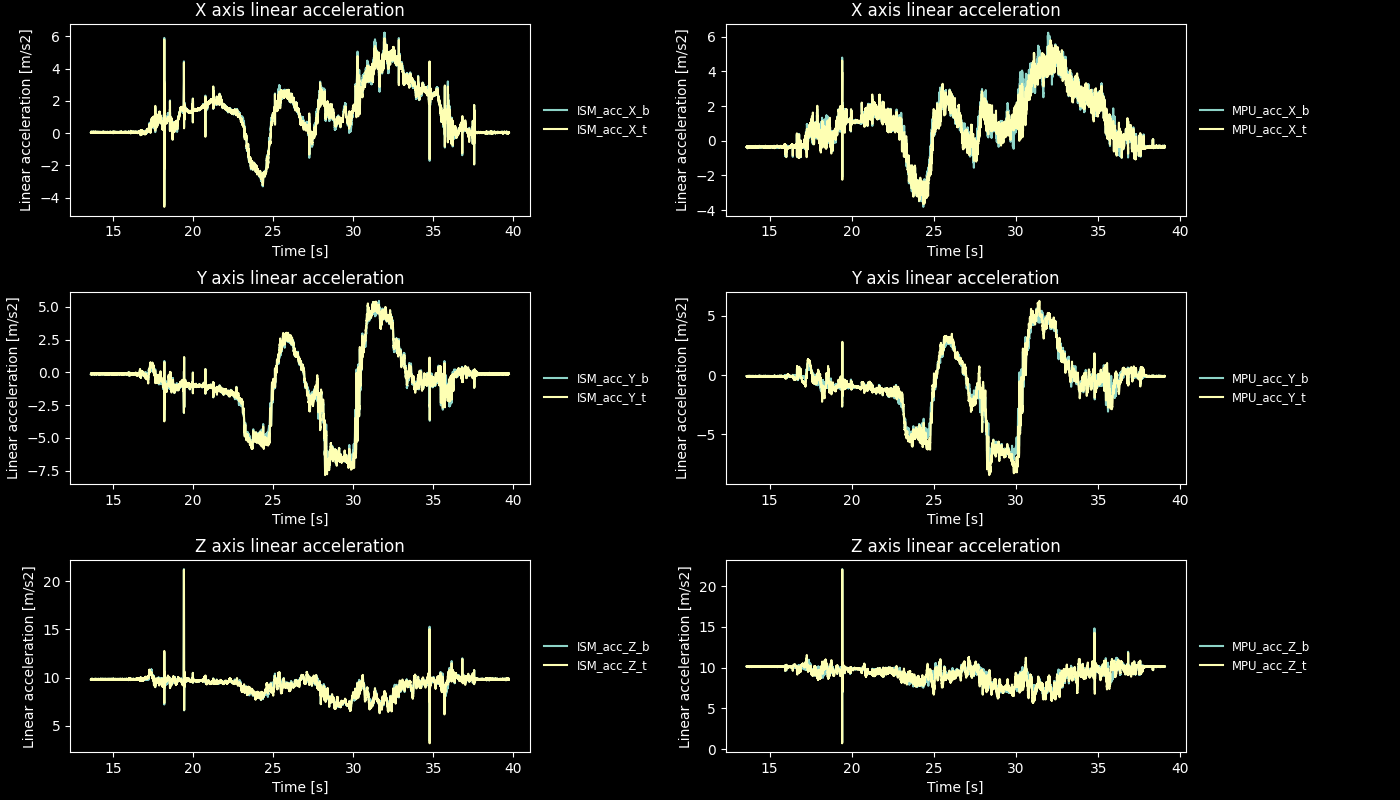

In [16]:
# Use dark theme for plots
plt.style.use('dark_background')

# Set up plot figure (canvas)
figure, axis = plt.subplots(3, 4,figsize=(14,8),gridspec_kw={'width_ratios': [2.6, 1,2.6,1]})

# First plot
axis[0, 0].plot(data_rot_ISM['mean_time_rel'], data_rot_ISM['mean_acc_X_b'], label='ISM_acc_X_b')
axis[0, 0].plot(data_trans_ISM['mean_time_rel'], data_trans_ISM['mean_acc_X_t'], label='ISM_acc_X_t')
axis[0, 0].set_title('X axis linear acceleration')
axis[0, 0].set_xlabel('Time [s]')
axis[0, 0].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_0_0,l_0_0 = axis[0,0].get_legend_handles_labels()
axis[0,1].legend(h_0_0,l_0_0,borderaxespad=0, mode='expand', loc='center', fontsize='small',frameon=False)
axis[0,1].axis("tight")
axis[0,1].axis("off")


# Second plot
axis[0, 2].plot(data_rot_MPU['mean_time_rel'], data_rot_MPU['mean_acc_X_b'], label='MPU_acc_X_b')
axis[0, 2].plot(data_trans_MPU['mean_time_rel'], data_trans_MPU['mean_acc_X_t'], label='MPU_acc_X_t')
axis[0, 2].set_title('X axis linear acceleration')
axis[0, 2].set_xlabel('Time [s]')
axis[0, 2].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_0_2,l_0_2 = axis[0,2].get_legend_handles_labels()
axis[0,3].legend(h_0_2,l_0_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[0,3].axis("tight")
axis[0,3].axis("off")


# Third plot 
axis[1, 0].plot(data_rot_ISM['mean_time_rel'], data_rot_ISM['mean_acc_Y_b'], label='ISM_acc_Y_b')
axis[1, 0].plot(data_trans_ISM['mean_time_rel'], data_trans_ISM['mean_acc_Y_t'], label='ISM_acc_Y_t')
axis[1, 0].set_title('Y axis linear acceleration')
axis[1, 0].set_xlabel('Time [s]')
axis[1, 0].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_1_0,l_1_0 = axis[1,0].get_legend_handles_labels()
axis[1,1].legend(h_1_0,l_1_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,1].axis("tight")
axis[1,1].axis("off")


# Fourth plot
axis[1, 2].plot(data_rot_MPU['mean_time_rel'], data_rot_MPU['mean_acc_Y_b'], label='MPU_acc_Y_b')
axis[1, 2].plot(data_trans_MPU['mean_time_rel'], data_trans_MPU['mean_acc_Y_t'], label='MPU_acc_Y_t')
axis[1, 2].set_title('Y axis linear acceleration')
axis[1, 2].set_xlabel('Time [s]')
axis[1, 2].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_1_2,l_1_2 = axis[1,2].get_legend_handles_labels()
axis[1,3].legend(h_1_2,l_1_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,3].axis("tight")
axis[1,3].axis("off")


#Fifth plot
axis[2, 0].plot(data_rot_ISM['mean_time_rel'], data_rot_ISM['mean_acc_Z_b'], label='ISM_acc_Z_b')
axis[2, 0].plot(data_trans_ISM['mean_time_rel'], data_trans_ISM['mean_acc_Z_t'], label='ISM_acc_Z_t')
axis[2, 0].set_title('Z axis linear acceleration')
axis[2, 0].set_xlabel('Time [s]')
axis[2, 0].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_2_0,l_2_0 = axis[2,0].get_legend_handles_labels()
axis[2,1].legend(h_2_0,l_2_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,1].axis("tight")
axis[2,1].axis("off")


# Sixth plot
axis[2, 2].plot(data_rot_MPU['mean_time_rel'], data_rot_MPU['mean_acc_Z_b'], label='MPU_acc_Z_b')
axis[2, 2].plot(data_trans_MPU['mean_time_rel'], data_trans_MPU['mean_acc_Z_t'], label='MPU_acc_Z_t')
axis[2, 2].set_title('Z axis linear acceleration')
axis[2, 2].set_xlabel('Time [s]')
axis[2, 2].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_2_2,l_2_2 = axis[2,2].get_legend_handles_labels()
axis[2,3].legend(h_2_2,l_2_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,3].axis("tight")
axis[2,3].axis("off")

figure.subplots_adjust(left=0.05,
                    bottom=0.06, 
                    right=0.98, 
                    top=0.97, 
                    wspace=0.03, 
                    hspace=0.4)
#plt.subplot_tool()
#figure.tight_layout(pad=0.1, w_pad=0, h_pad=0.01)

### Join two sensors data in single point

In [17]:
# Join two sensors data
ISM_weight = 100
MPU_weight = 1

# drop starting and ending rows with only one sensor 
start = max([data_trans_ISM.index[0],data_trans_MPU.index[0]])
end = min([data_trans_ISM.index[-1],data_trans_MPU.index[-1]])

#data_joined = (pd.concat((data_trans_ISM*ISM_weight, data_trans_MPU*MPU_weight), axis=1).mean(axis=1)/(ISM_weight+MPU_weight))#[start:end]
data_joined = pd.concat((data_trans_ISM.loc[start:end] * ISM_weight, data_trans_MPU.loc[start:end] * MPU_weight))#.mean(axis=0)#, axis=1)#.mean(axis=1)
data_joined=data_joined.groupby(data_joined.index).sum()/(ISM_weight + MPU_weight)

In [18]:
data_joined.head()

,mean_time_rel,mean_acc_X_b,mean_acc_Y_b,mean_acc_Z_b,mean_gyro_X_b,mean_gyro_Y_b,mean_gyro_Z_b,mean_gyro_X_b_der,mean_gyro_Y_b_der,mean_gyro_Z_b_der,mean_acc_X_t,mean_acc_Y_t,mean_acc_Z_t
2022-05-14 12:12:35.581000+00:00,13.605351,0.041097,-0.132144,9.808396,0.075282,-0.590966,-0.430478,0.0,0.0,0.0,0.041076,-0.132142,9.808390
2022-05-14 12:12:35.582000+00:00,13.606430,0.049194,-0.115302,9.844456,0.227570,0.723115,0.268251,0.0,0.0,0.0,0.049182,-0.115295,9.844446
2022-05-14 12:12:35.583000+00:00,13.607377,0.043761,-0.117127,9.836579,0.673802,0.511896,-0.987301,0.0,0.0,0.0,0.043710,-0.117184,9.836521
2022-05-14 12:12:35.584000+00:00,13.608353,0.050135,-0.119468,9.816662,-0.276538,0.504876,-0.209944,0.0,0.0,0.0,0.050122,-0.119487,9.816650
2022-05-14 12:12:35.585000+00:00,13.609340,0.048392,-0.115793,9.793182,-0.893451,-0.729514,0.311639,0.0,0.0,0.0,0.048377,-0.115826,9.793119


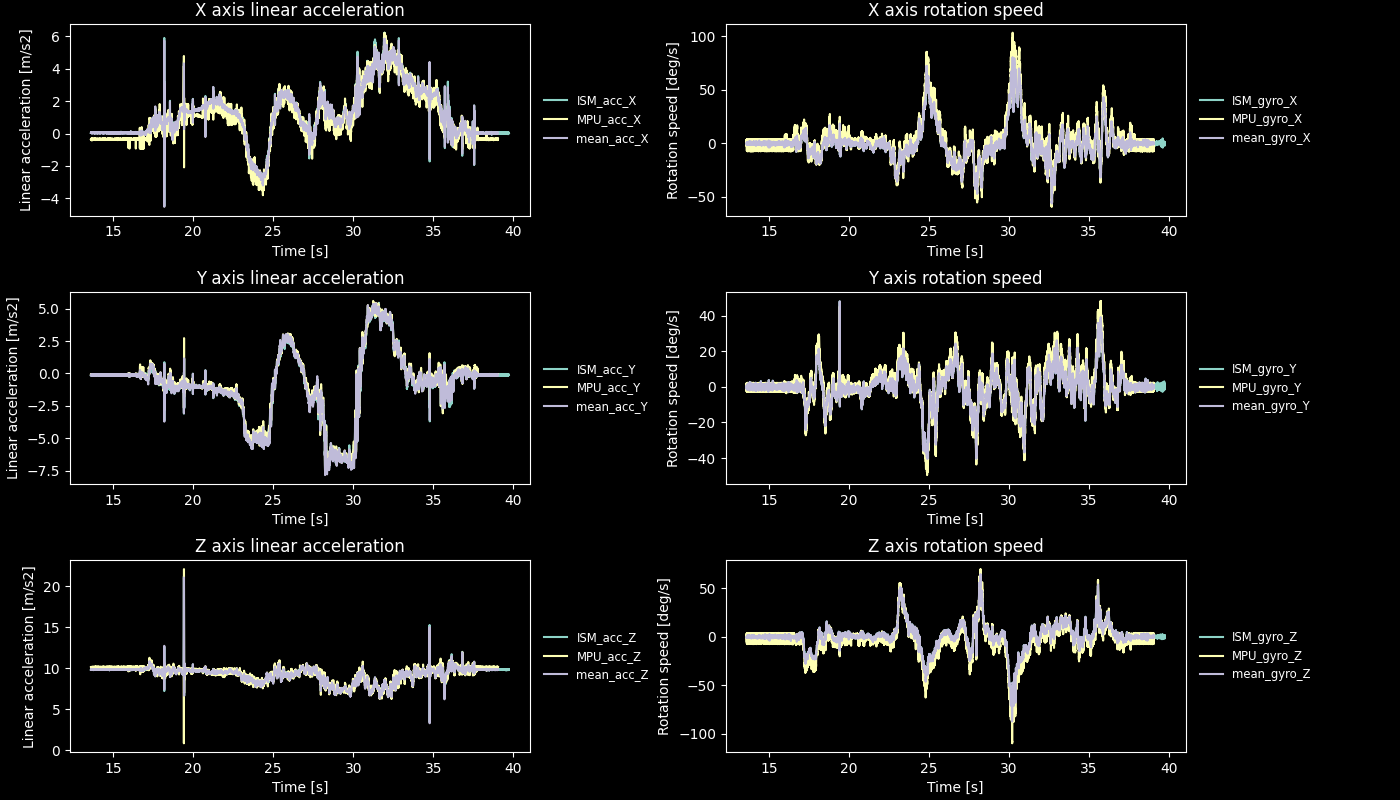

In [19]:
# Use dark theme for plots
plt.style.use('dark_background')

# Set up plot figure (canvas)
figure, axis = plt.subplots(3, 4,figsize=(14,8),gridspec_kw={'width_ratios': [2.6, 1,2.6,1]})

# First plot
axis[0, 0].plot(data_rot_ISM['mean_time_rel'], data_rot_ISM['mean_acc_X_b'], label='ISM_acc_X')
axis[0, 0].plot(data_rot_MPU['mean_time_rel'], data_rot_MPU['mean_acc_X_b'], label='MPU_acc_X')
axis[0, 0].plot(data_joined['mean_time_rel'], data_joined['mean_acc_X_t'], label='mean_acc_X')
axis[0, 0].set_title('X axis linear acceleration')
axis[0, 0].set_xlabel('Time [s]')
axis[0, 0].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_0_0,l_0_0 = axis[0,0].get_legend_handles_labels()
axis[0,1].legend(h_0_0,l_0_0,borderaxespad=0, mode='expand', loc='center', fontsize='small',frameon=False)
axis[0,1].axis("tight")
axis[0,1].axis("off")


# Second plot
axis[0, 2].plot(data_rot_ISM['mean_time_rel'], data_rot_ISM['mean_gyro_X_b'], label='ISM_gyro_X')
axis[0, 2].plot(data_rot_MPU['mean_time_rel'], data_rot_MPU['mean_gyro_X_b'], label='MPU_gyro_X')
axis[0, 2].plot(data_joined['mean_time_rel'], data_joined['mean_gyro_X_b'], label='mean_gyro_X')
axis[0, 2].set_title('X axis rotation speed')
axis[0, 2].set_xlabel('Time [s]')
axis[0, 2].set_ylabel('Rotation speed [deg/s]')
# Set legend next to plot
h_0_2,l_0_2 = axis[0,2].get_legend_handles_labels()
axis[0,3].legend(h_0_2,l_0_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[0,3].axis("tight")
axis[0,3].axis("off")


# Third plot 
axis[1, 0].plot(data_rot_ISM['mean_time_rel'], data_rot_ISM['mean_acc_Y_b'], label='ISM_acc_Y')
axis[1, 0].plot(data_rot_MPU['mean_time_rel'], data_rot_MPU['mean_acc_Y_b'], label='MPU_acc_Y')
axis[1, 0].plot(data_joined['mean_time_rel'], data_joined['mean_acc_Y_t'], label='mean_acc_Y')
axis[1, 0].set_title('Y axis linear acceleration')
axis[1, 0].set_xlabel('Time [s]')
axis[1, 0].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_1_0,l_1_0 = axis[1,0].get_legend_handles_labels()
axis[1,1].legend(h_1_0,l_1_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,1].axis("tight")
axis[1,1].axis("off")


# Fourth plot
axis[1, 2].plot(data_rot_ISM['mean_time_rel'], data_rot_ISM['mean_gyro_Y_b'], label='ISM_gyro_Y')
axis[1, 2].plot(data_rot_MPU['mean_time_rel'], data_rot_MPU['mean_gyro_Y_b'], label='MPU_gyro_Y')
axis[1, 2].plot(data_joined['mean_time_rel'], data_joined['mean_gyro_Y_b'], label='mean_gyro_Y')
axis[1, 2].set_title('Y axis rotation speed')
axis[1, 2].set_xlabel('Time [s]')
axis[1, 2].set_ylabel('Rotation speed [deg/s]')
# Set legend next to plot
h_1_2,l_1_2 = axis[1,2].get_legend_handles_labels()
axis[1,3].legend(h_1_2,l_1_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,3].axis("tight")
axis[1,3].axis("off")


#Fifth plot
axis[2, 0].plot(data_rot_ISM['mean_time_rel'], data_rot_ISM['mean_acc_Z_b'], label='ISM_acc_Z')
axis[2, 0].plot(data_rot_MPU['mean_time_rel'], data_rot_MPU['mean_acc_Z_b'], label='MPU_acc_Z')
axis[2, 0].plot(data_joined['mean_time_rel'], data_joined['mean_acc_Z_t'], label='mean_acc_Z')
axis[2, 0].set_title('Z axis linear acceleration')
axis[2, 0].set_xlabel('Time [s]')
axis[2, 0].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_2_0,l_2_0 = axis[2,0].get_legend_handles_labels()
axis[2,1].legend(h_2_0,l_2_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,1].axis("tight")
axis[2,1].axis("off")


# Sixth plot
axis[2, 2].plot(data_rot_ISM['mean_time_rel'], data_rot_ISM['mean_gyro_Z_b'], label='ISM_gyro_Z')
axis[2, 2].plot(data_rot_MPU['mean_time_rel'], data_rot_MPU['mean_gyro_Z_b'], label='MPU_gyro_Z')
axis[2, 2].plot(data_joined['mean_time_rel'], data_joined['mean_gyro_Z_b'], label='mean_gyro_Z')
axis[2, 2].set_title('Z axis rotation speed')
axis[2, 2].set_xlabel('Time [s]')
axis[2, 2].set_ylabel('Rotation speed [deg/s]')
# Set legend next to plot
h_2_2,l_2_2 = axis[2,2].get_legend_handles_labels()
axis[2,3].legend(h_2_2,l_2_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,3].axis("tight")
axis[2,3].axis("off")

figure.subplots_adjust(left=0.05,
                    bottom=0.06, 
                    right=0.98, 
                    top=0.97, 
                    wspace=0.03, 
                    hspace=0.4)
#plt.subplot_tool()
#figure.tight_layout(pad=0.1, w_pad=0, h_pad=0.01)

In [20]:
translator = AngleCalculator()
kalman = KalmanFilter()
data = data_joined.copy()

In [21]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                       'display.precision', 3):
    print(data.describe())
    

       mean_time_rel  mean_acc_X_b  mean_acc_Y_b  mean_acc_Z_b  mean_gyro_X_b  \
count      25439.000     25439.000     25439.000     25439.000      25439.000   
mean          26.324         1.214        -0.862         9.228         -0.029   
std            7.344         1.580         2.547         0.896         16.406   
min           13.605        -4.425        -7.740         3.512        -56.277   
25%           19.965         0.050        -1.458         8.803         -7.054   
50%           26.324         1.032        -0.523         9.564         -0.554   
75%           32.684         2.073        -0.073         9.822          2.106   
max           39.043         6.221         5.449        21.158         80.460   

       mean_gyro_Y_b  mean_gyro_Z_b  mean_gyro_X_b_der  mean_gyro_Y_b_der  \
count      25439.000      25439.000          2.544e+04          25439.000   
mean          -0.325          0.264         -4.094e-04              0.002   
std            9.697         14.464    

In [22]:
#data = bias.apply_bias(data)
# calculate phi and theta from accelerometers data
data = translator.calculate_angles_1(data)
# apply "Kalman filter" to phi and theta calculations (also get psi as an integral)
data = kalman.apply_kalman(data, extra=True)

# rotate sensors accelerations from sensor frame to earths frame using quaternions
data = translator.rotate_acc(data)

In [23]:
# get points 3D
curve = SensorCurve3D()

fun_iter = 0

In [24]:
    # def set_input_tables(self, x_acc, y_acc, z_acc, times):
    #     self.x_acc_list = x_acc[:]
    #     self.y_acc_list = y_acc[:]
    #     self.z_acc_list = z_acc[:]
    #     self.time_list = times[:]
    #     pass

curve.set_input_tables(x_acc=data['acc_X_e'].to_list(),y_acc=data['acc_Y_e'].to_list(), z_acc=data['acc_Z_e'].to_list(), times=data['mean_time_rel'].to_list())

#curve.fill_curve(data, 9.8159, None)
curve.fill_curve_from_input_tables(9.8159, None)

In [25]:
print(data.describe())

       mean_time_rel  mean_acc_X_b  mean_acc_Y_b  mean_acc_Z_b  mean_gyro_X_b  \
count   25439.000000  25439.000000  25439.000000  25439.000000   25439.000000   
mean       26.324403      1.214418     -0.862054      9.228129      -0.029445   
std         7.343750      1.580095      2.546965      0.895581      16.405668   
min        13.605351     -4.424540     -7.740071      3.512387     -56.277285   
25%        19.965116      0.049830     -1.458485      8.802930      -7.054401   
50%        26.324409      1.031998     -0.522952      9.563864      -0.554375   
75%        32.683868      2.073452     -0.073486      9.822181       2.105572   
max        39.043437      6.221096      5.449144     21.157889      80.460004   

       mean_gyro_Y_b  mean_gyro_Z_b  mean_gyro_X_b_der  mean_gyro_Y_b_der  \
count   25439.000000   25439.000000       25439.000000       25439.000000   
mean       -0.325051       0.264341          -0.000409           0.002273   
std         9.697288      14.464197    

speed_corrections = {'x': curve.x_speed_last / 8000, 'y': curve.y_speed_last / 8000, 'z': curve.z_speed_last / 8000}
curve.fill_curve(data, 0.001, 9.8159, speed_corrections)

## Przyspieszenia w stosunku do ziemi

In [26]:
data[['acc_X_e','acc_Y_e','acc_Z_e']]

,acc_X_e,acc_Y_e,acc_Z_e
2022-05-14 12:12:35.581000+00:00,0.040966,-0.132129,9.808391
2022-05-14 12:12:35.582000+00:00,0.049186,-0.115297,9.844446
2022-05-14 12:12:35.583000+00:00,0.043792,-0.117279,9.836519
2022-05-14 12:12:35.584000+00:00,0.050280,-0.119511,9.816649
2022-05-14 12:12:35.585000+00:00,0.048400,-0.115674,9.793121
...,...,...,...
2022-05-14 12:13:01.015000+00:00,-0.041988,-0.032851,9.809437
2022-05-14 12:13:01.016000+00:00,-0.049304,0.023469,9.827491
2022-05-14 12:13:01.017000+00:00,-0.069886,0.007085,9.837405
2022-05-14 12:13:01.018000+00:00,-0.075034,-0.029362,9.817101


In [27]:
(data['acc_X_e']**2+data['acc_Y_e']**2+data['acc_Z_e']**2)**0.5

2022-05-14 12:12:35.581000+00:00    9.809366
2022-05-14 12:12:35.582000+00:00    9.845244
2022-05-14 12:12:35.583000+00:00    9.837316
2022-05-14 12:12:35.584000+00:00    9.817505
2022-05-14 12:12:35.585000+00:00    9.793924
                                      ...   
2022-05-14 12:13:01.015000+00:00    9.809582
2022-05-14 12:13:01.016000+00:00    9.827642
2022-05-14 12:13:01.017000+00:00    9.837656
2022-05-14 12:13:01.018000+00:00    9.817431
2022-05-14 12:13:01.019000+00:00    9.834930
Length: 25439, dtype: float64

In [28]:
### Przyspieszenia RAW 

In [29]:
data_raw_ISM[['mean_acc_X','mean_acc_Y','mean_acc_Z']]

,mean_acc_X,mean_acc_Y,mean_acc_Z
2022-05-14 12:12:35.581000+00:00,-9.788274,-0.239906,0.116362
2022-05-14 12:12:35.582000+00:00,-9.825146,-0.222668,0.124502
2022-05-14 12:12:35.583000+00:00,-9.817125,-0.224463,0.119115
2022-05-14 12:12:35.584000+00:00,-9.796774,-0.226858,0.125699
2022-05-14 12:12:35.585000+00:00,-9.772831,-0.223266,0.123904
...,...,...,...
2022-05-14 12:13:01.698000+00:00,-9.797372,-0.246610,0.086194
2022-05-14 12:13:01.699000+00:00,-9.792584,-0.223865,0.112531
2022-05-14 12:13:01.700000+00:00,-9.827301,-0.225062,0.104151
2022-05-14 12:13:01.701000+00:00,-9.862018,-0.215485,0.110137


In [30]:
(data_raw_ISM['mean_acc_X']**2+data_raw_ISM['mean_acc_Y']**2+data_raw_ISM['mean_acc_Z']**2)**0.5

2022-05-14 12:12:35.581000+00:00    9.791905
2022-05-14 12:12:35.582000+00:00    9.828457
2022-05-14 12:12:35.583000+00:00    9.820413
2022-05-14 12:12:35.584000+00:00    9.800206
2022-05-14 12:12:35.585000+00:00    9.776166
                                      ...   
2022-05-14 12:13:01.698000+00:00    9.800854
2022-05-14 12:13:01.699000+00:00    9.795789
2022-05-14 12:13:01.700000+00:00    9.830429
2022-05-14 12:13:01.701000+00:00    9.864986
2022-05-14 12:13:01.702000+00:00    9.834004
Length: 26122, dtype: float64

In [31]:
data_raw_MPU[['mean_acc_X','mean_acc_Y','mean_acc_Z']]

,mean_acc_X,mean_acc_Y,mean_acc_Z
2022-05-14 12:12:35.581000+00:00,4.905869,-4.756227,-7.863995
2022-05-14 12:12:35.582000+00:00,4.905869,-4.728693,-7.836461
2022-05-14 12:12:35.583000+00:00,4.905869,-4.721510,-7.847235
2022-05-14 12:12:35.584000+00:00,4.905869,-4.725101,-7.868784
2022-05-14 12:12:35.585000+00:00,4.905869,-4.743058,-7.877164
...,...,...,...
2022-05-14 12:13:01.015000+00:00,4.905869,-4.783761,-7.879558
2022-05-14 12:13:01.016000+00:00,4.905869,-4.747847,-7.903501
2022-05-14 12:13:01.017000+00:00,4.905869,-4.721510,-7.905895
2022-05-14 12:13:01.018000+00:00,4.905869,-4.731087,-7.910684


In [32]:
(data_raw_MPU['mean_acc_X']**2+data_raw_MPU['mean_acc_Y']**2+data_raw_MPU['mean_acc_Z']**2)**0.5

2022-05-14 12:12:35.581000+00:00    10.417853
2022-05-14 12:12:35.582000+00:00    10.384518
2022-05-14 12:12:35.583000+00:00    10.389384
2022-05-14 12:12:35.584000+00:00    10.407300
2022-05-14 12:12:35.585000+00:00    10.421797
                                      ...    
2022-05-14 12:13:01.015000+00:00    10.442191
2022-05-14 12:13:01.016000+00:00    10.443894
2022-05-14 12:13:01.017000+00:00    10.433762
2022-05-14 12:13:01.018000+00:00    10.441726
2022-05-14 12:13:01.019000+00:00    10.435238
Length: 25439, dtype: float64

In [33]:
### Przyspieszenia bias

In [34]:
data_bias_ISM[['mean_acc_X_b','mean_acc_Y_b','mean_acc_Z_b']]

,mean_acc_X_b,mean_acc_Y_b,mean_acc_Z_b
2022-05-14 12:12:35.581000+00:00,-9.805163,-0.132406,0.044982
2022-05-14 12:12:35.582000+00:00,-9.841914,-0.115200,0.053105
2022-05-14 12:12:35.583000+00:00,-9.833920,-0.116992,0.047730
2022-05-14 12:12:35.584000+00:00,-9.813635,-0.119382,0.054300
2022-05-14 12:12:35.585000+00:00,-9.789771,-0.115798,0.052508
...,...,...,...
2022-05-14 12:13:01.698000+00:00,-9.814232,-0.139097,0.014878
2022-05-14 12:13:01.699000+00:00,-9.809459,-0.116395,0.041159
2022-05-14 12:13:01.700000+00:00,-9.844062,-0.117590,0.032797
2022-05-14 12:13:01.701000+00:00,-9.878665,-0.108031,0.038770


In [35]:
(data_bias_ISM['mean_acc_X_b']**2+data_bias_ISM['mean_acc_Y_b']**2+data_bias_ISM['mean_acc_Z_b']**2)**0.5

2022-05-14 12:12:35.581000+00:00    9.806161
2022-05-14 12:12:35.582000+00:00    9.842732
2022-05-14 12:12:35.583000+00:00    9.834732
2022-05-14 12:12:35.584000+00:00    9.814512
2022-05-14 12:12:35.585000+00:00    9.790597
                                      ...   
2022-05-14 12:13:01.698000+00:00    9.815229
2022-05-14 12:13:01.699000+00:00    9.810236
2022-05-14 12:13:01.700000+00:00    9.844819
2022-05-14 12:13:01.701000+00:00    9.879332
2022-05-14 12:13:01.702000+00:00    9.848383
Length: 26122, dtype: float64

In [36]:
data_bias_MPU[['mean_acc_X_b','mean_acc_Y_b','mean_acc_Z_b']]

,mean_acc_X_b,mean_acc_Y_b,mean_acc_Z_b
2022-05-14 12:12:35.581000+00:00,4.967075,-4.817194,-7.409792
2022-05-14 12:12:35.582000+00:00,4.967075,-4.789565,-7.382613
2022-05-14 12:12:35.583000+00:00,4.967075,-4.782357,-7.393248
2022-05-14 12:12:35.584000+00:00,4.967075,-4.785961,-7.414519
2022-05-14 12:12:35.585000+00:00,4.967075,-4.803980,-7.422791
...,...,...,...
2022-05-14 12:13:01.015000+00:00,4.967075,-4.844824,-7.425154
2022-05-14 12:13:01.016000+00:00,4.967075,-4.808785,-7.448788
2022-05-14 12:13:01.017000+00:00,4.967075,-4.782357,-7.451152
2022-05-14 12:13:01.018000+00:00,4.967075,-4.791967,-7.455879


In [37]:
(data_bias_MPU['mean_acc_X_b']**2+data_bias_MPU['mean_acc_Y_b']**2+data_bias_MPU['mean_acc_Z_b']**2)**0.5

2022-05-14 12:12:35.581000+00:00    10.138157
2022-05-14 12:12:35.582000+00:00    10.105184
2022-05-14 12:12:35.583000+00:00    10.109545
2022-05-14 12:12:35.584000+00:00    10.126814
2022-05-14 12:12:35.585000+00:00    10.141395
                                      ...    
2022-05-14 12:13:01.015000+00:00    10.162533
2022-05-14 12:13:01.016000+00:00    10.162711
2022-05-14 12:13:01.017000+00:00    10.151967
2022-05-14 12:13:01.018000+00:00    10.159966
2022-05-14 12:13:01.019000+00:00    10.155112
Length: 25439, dtype: float64

In [38]:
### Przyspieszenia Rotacja

In [39]:
data_rot_ISM[['mean_acc_X_b','mean_acc_Y_b','mean_acc_Z_b']]

,mean_acc_X_b,mean_acc_Y_b,mean_acc_Z_b
2022-05-14 12:12:35.581000+00:00,0.044982,-0.132406,9.805163
2022-05-14 12:12:35.582000+00:00,0.053105,-0.115200,9.841914
2022-05-14 12:12:35.583000+00:00,0.047730,-0.116992,9.833920
2022-05-14 12:12:35.584000+00:00,0.054300,-0.119382,9.813635
2022-05-14 12:12:35.585000+00:00,0.052508,-0.115798,9.789771
...,...,...,...
2022-05-14 12:13:01.698000+00:00,0.014878,-0.139097,9.814232
2022-05-14 12:13:01.699000+00:00,0.041159,-0.116395,9.809459
2022-05-14 12:13:01.700000+00:00,0.032797,-0.117590,9.844062
2022-05-14 12:13:01.701000+00:00,0.038770,-0.108031,9.878665


In [40]:
(data_rot_ISM['mean_acc_X_b']**2+data_rot_ISM['mean_acc_Y_b']**2+data_rot_ISM['mean_acc_Z_b']**2)**0.5

2022-05-14 12:12:35.581000+00:00    9.806161
2022-05-14 12:12:35.582000+00:00    9.842732
2022-05-14 12:12:35.583000+00:00    9.834732
2022-05-14 12:12:35.584000+00:00    9.814512
2022-05-14 12:12:35.585000+00:00    9.790597
                                      ...   
2022-05-14 12:13:01.698000+00:00    9.815229
2022-05-14 12:13:01.699000+00:00    9.810236
2022-05-14 12:13:01.700000+00:00    9.844819
2022-05-14 12:13:01.701000+00:00    9.879332
2022-05-14 12:13:01.702000+00:00    9.848383
Length: 26122, dtype: float64

In [41]:
data_rot_MPU[['mean_acc_X_b','mean_acc_Y_b','mean_acc_Z_b']]

,mean_acc_X_b,mean_acc_Y_b,mean_acc_Z_b
2022-05-14 12:12:35.581000+00:00,-0.347380,-0.105982,10.131649
2022-05-14 12:12:35.582000+00:00,-0.341976,-0.125519,10.098616
2022-05-14 12:12:35.583000+00:00,-0.353100,-0.130615,10.102532
2022-05-14 12:12:35.584000+00:00,-0.366339,-0.128067,10.119375
2022-05-14 12:12:35.585000+00:00,-0.363178,-0.115325,10.134234
...,...,...,...
2022-05-14 12:13:01.015000+00:00,-0.344428,-0.086445,10.156326
2022-05-14 12:13:01.016000+00:00,-0.379159,-0.111928,10.155019
2022-05-14 12:13:01.017000+00:00,-0.394044,-0.130615,10.143476
2022-05-14 12:13:01.018000+00:00,-0.392581,-0.123820,10.151624


In [42]:
(data_rot_MPU['mean_acc_X_b']**2+data_rot_MPU['mean_acc_Y_b']**2+data_rot_MPU['mean_acc_Z_b']**2)**0.5

2022-05-14 12:12:35.581000+00:00    10.138157
2022-05-14 12:12:35.582000+00:00    10.105184
2022-05-14 12:12:35.583000+00:00    10.109545
2022-05-14 12:12:35.584000+00:00    10.126814
2022-05-14 12:12:35.585000+00:00    10.141395
                                      ...    
2022-05-14 12:13:01.015000+00:00    10.162533
2022-05-14 12:13:01.016000+00:00    10.162711
2022-05-14 12:13:01.017000+00:00    10.151967
2022-05-14 12:13:01.018000+00:00    10.159966
2022-05-14 12:13:01.019000+00:00    10.155112
Length: 25439, dtype: float64

In [43]:
def opt_iteration(bias_tab):
    global fun_iter
    global data
    global data_joined
    global curve
    global translator
    #global kalman
    fun_iter += 1

    print('Iteration: ', fun_iter)
    print('Input: ', bias_tab)
    # apply new bias to input data
    #bias.change_bias_acc_linear(bias_tab[0], bias_tab[1], bias_tab[2], bias_tab[3], bias_tab[4], bias_tab[5])
    # bias.change_bias_gyro_const(bias_tab[3], bias_tab[4], bias_tab[5])
    # g_temp= bias_tab[6]
    g_temp = 9.8159
    data['mean_acc_X_t'] = data_joined['mean_acc_X_t'] + bias_tab[0]
    data['mean_acc_Y_t'] = data_joined['mean_acc_Y_t'] + bias_tab[1]
    data['mean_acc_Z_t'] = data_joined['mean_acc_Z_t'] + bias_tab[2]
    #bias.apply_bias(data)
    # recalculate Kalman
    #data = translator.calculate_angles_1(data)
    #data = kalman.apply_kalman(data)
    #print(data.describe())
    #print('0')
    data = translator.rotate_acc(data)
    #print('1')
    curve.set_input_tables(x_acc=data['acc_X_e'].to_list(),y_acc=data['acc_Y_e'].to_list(), z_acc=data['acc_Z_e'].to_list(), times=data['mean_time_rel'].to_list())
    curve.fill_curve_from_input_tables(9.8159, None)
    #curve.fill_curve(data, g_temp,None)
    #print('2')
    speed_arg = curve.x_speed_last ** 2 + curve.y_speed_last ** 2 + curve.z_speed_last ** 2
    #print('3')
    pos_arg = curve.x_point_last ** 2 + curve.y_point_last ** 2 + curve.z_point_last ** 2
    #deg_arg = kalman.psi_hat ** 2
    #acc_arg = (curve.acc_last - 9.8159) ** 2
    out = speed_arg + pos_arg #+ acc_arg * 10000  + pos_arg# + deg_arg
    print('Output: ', out, ' dx: ', curve.x_speed_last)
    return out

In [44]:
# run single opt iteration
#x_0 = array([bias.bias_linear['a_x_acc'], bias.bias_linear['a_y_acc'], bias.bias_linear['a_z_acc'],
#                bias.bias_linear['b_x_acc'], bias.bias_linear['b_y_acc'], bias.bias_linear['b_z_acc']])
# x_0 = np.array([bias.bias_const['x_acc'], bias.bias_const['y_acc'], bias.bias_const['z_acc']])
#                bias.bias_const['x_gyro'], bias.bias_const['y_gyro'], bias.bias_const['z_gyro']])
x_0 = array([0.0,0.0,0.0])
# func = opt_iteration(x_0)
# print(func)
#data = data_joined.copy()
minimize(opt_iteration, x_0, method='L-BFGS-B', bounds=[(-0.1, 0.1), (-0.1, 0.1), (-0.1, 0.1)],
        options={'maxfun': 50, 'eps': 0.01, 'ftol': 0.001, 'iprint': 0})

# minimize(opt_iteration, x_0, method='L-BFGS-B',  # method='TNC',
#         bounds=[(0.98, 1.02), (0.98, 1.02), (0.98, 1.02), (-0.15, 0.15), (-0.15, 0.15), (-0.15, 0.15)],
#         options={'maxiter': 100, 'eps': 0.0001, 'ftol': 0.001})



Iteration:  1
Input:  [0. 0. 0.]
Output:  65.50529487130912  dx:  0.7194828392350081
Iteration:  2
Input:  [0.01 0.   0.  ]
Output:  124.67378452035925  dx:  0.9630327746994559
Iteration:  3
Input:  [0.   0.01 0.  ]
Output:  70.67004407531343  dx:  0.7439971561896778
Iteration:  4
Input:  [0.   0.   0.01]
Output:  87.769621649561  dx:  0.6843063006943486
Iteration:  5
Input:  [-0.1 -0.1 -0.1]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10
Output:  2463.108018811359  dx:  -1.6093942995495323
Iteration:  6
Input:  [-0.09 -0.1  -0.1 ]
Output:  2325.5878058443614  dx:  -1.3658443640850753
Iteration:  7
Input:  [-0.1  -0.09 -0.1 ]
Output:  2269.9443547164965  dx:  -1.5848799825948692
Iteration:  8
Input:  [-0.1  -0.1  -0.09]
Output:  2287.425051493635  dx:  -1.644570838090207
Iteration:  9
Input:  [-0.01152231 -0.01152231 -0.01152231]
Output:  39.51058331875069  dx:  0.45114230572041825
Iteration:  10
Input:  [-0.00152231 -0

      fun: 8.334924425061788
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00702011, -0.02751698,  0.01014208])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 24
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([-0.02958527, -0.00263556, -0.01171004])


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      6     0     0   2.752D-02   8.335D+00

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


# Get dataframe from device 3d curve

In [45]:
curve_df = curve.return_as_df()
with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(curve_df.head())

                   X_p_e      Y_p_e      Z_p_e
mean_time_rel                                 
13.605         0.000e+00  0.000e+00  0.000e+00
13.606         9.017e-09 -7.355e-08  5.127e-09
13.607         3.243e-08 -2.560e-07  2.439e-08
13.608         7.266e-08 -5.565e-07  5.907e-08
13.609         1.314e-07 -9.775e-07  9.228e-08


In [46]:
data.set_index('mean_time_rel', inplace=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(data.describe())

       mean_acc_X_b  mean_acc_Y_b  mean_acc_Z_b  mean_gyro_X_b  mean_gyro_Y_b  \
count     25439.000     25439.000     25439.000      25439.000      25439.000   
mean          1.214        -0.862         9.228         -0.029         -0.325   
std           1.580         2.547         0.896         16.406          9.697   
min          -4.425        -7.740         3.512        -56.277        -40.401   
25%           0.050        -1.458         8.803         -7.054         -3.693   
50%           1.032        -0.523         9.564         -0.554         -0.049   
75%           2.073        -0.073         9.822          2.106          3.802   
max           6.221         5.449        21.158         80.460         47.979   

       mean_gyro_Z_b  mean_gyro_X_b_der  mean_gyro_Y_b_der  mean_gyro_Z_b_der  \
count      25439.000          2.544e+04          25439.000          25439.000   
mean           0.264         -4.094e-04              0.002              0.001   
std           14.464       

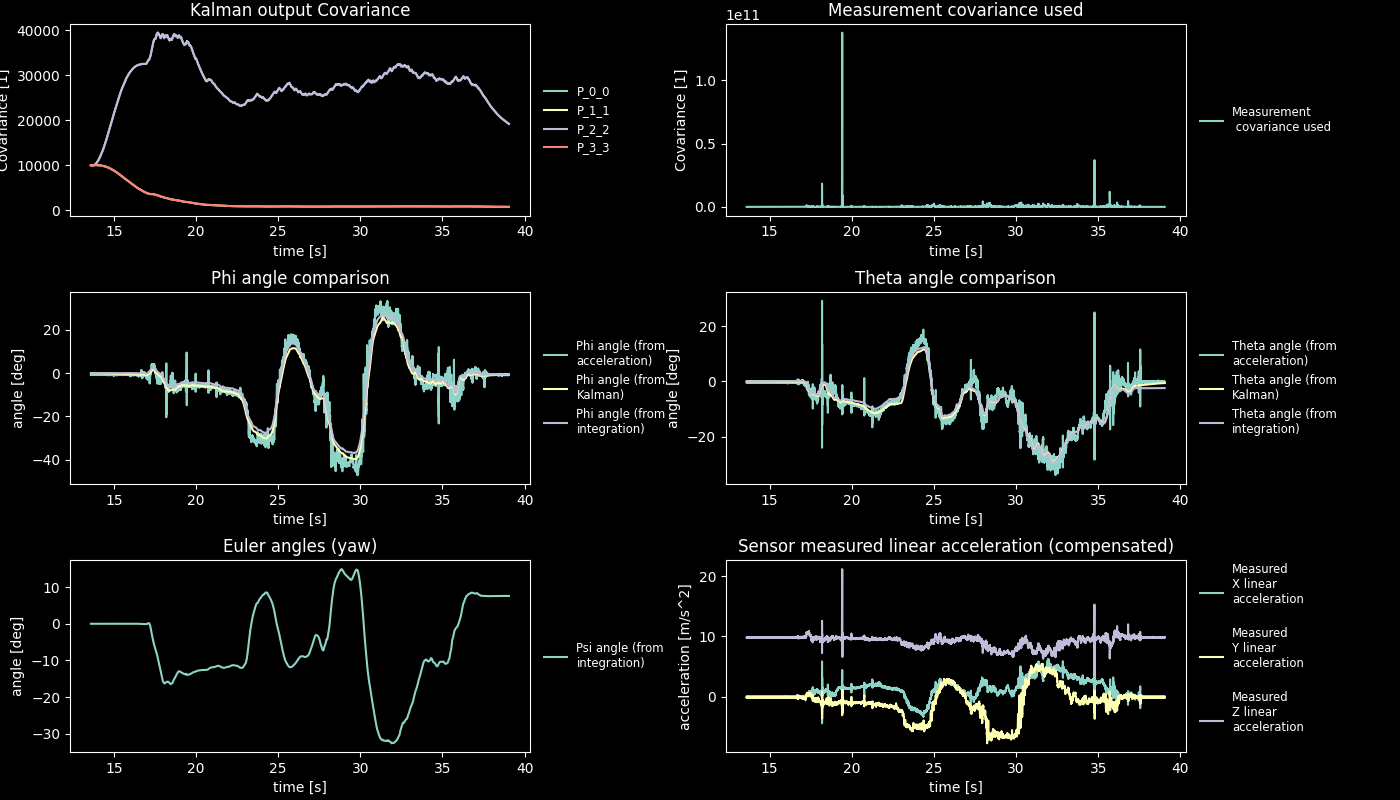

In [47]:
# Use dark theme for plots
plt.style.use('dark_background')

# Set up plot figure (canvas)
figure, axis = plt.subplots(3, 4,figsize=(14,8),gridspec_kw={'width_ratios': [2.6, 1,2.6,1]})

# First plot - Output estimate covariance
axis[0, 0].plot(data.index, data['P_0_0'], label='P_0_0')
axis[0, 0].plot(data.index, data['P_1_1'], label='P_1_1')
axis[0, 0].plot(data.index, data['P_2_2'], label='P_2_2')
axis[0, 0].plot(data.index, data['P_3_3'], label='P_3_3')
#axis[0, 0].plot(data.index, data['mean_acc_X'], label='sensor X raw')
#axis[0, 0].plot(data.index, data['mean_acc_Y'], label='sensor Y raw')
#axis[0, 0].plot(data.index, data['mean_acc_Z'], label='sensor Z raw')
axis[0, 0].set_title('Kalman output Covariance')
axis[0, 0].set_xlabel('time [s]')
axis[0, 0].set_ylabel('Covariance [1]')
# Set legend next to plot
h_0_0,l_0_0 = axis[0,0].get_legend_handles_labels()
axis[0,1].legend(h_0_0,l_0_0,borderaxespad=0, mode='expand', loc='center', fontsize='small',frameon=False)
axis[0,1].axis("tight")
axis[0,1].axis("off")



# Second plot - Gyroscope data
axis[0, 2].plot(data.index, data['R'], label='Measurement\n covariance used')
axis[0, 2].set_title('Measurement covariance used')
axis[0, 2].set_xlabel('time [s]')
axis[0, 2].set_ylabel('Covariance [1]')
# Set legend next to plot
h_0_2,l_0_2 = axis[0,2].get_legend_handles_labels()
axis[0,3].legend(h_0_2,l_0_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[0,3].axis("tight")
axis[0,3].axis("off")


# Third plot - Phi angle
axis[1, 0].plot(data.index, data['acc_phi'] * 180 / pi, label='Phi angle (from\nacceleration)')
axis[1, 0].plot(data.index, data['phi_hat'] * 180 / pi, label='Phi angle (from\nKalman)')
axis[1, 0].plot(data.index, data['int_phi'] * 180 / pi, label='Phi angle (from\nintegration)')
#axis[1, 0].plot(data.index, data['g_ground'], label='ground acceleration')
axis[1, 0].set_title('Phi angle comparison')
axis[1, 0].set_xlabel('time [s]')
axis[1, 0].set_ylabel('angle [deg]')
# Set legend next to plot
h_1_0,l_1_0 = axis[1,0].get_legend_handles_labels()
axis[1,1].legend(h_1_0,l_1_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,1].axis("tight")
axis[1,1].axis("off")


# Fourth plot - Theta angle
axis[1, 2].plot(data.index, data['acc_theta'] * 180 / pi, label='Theta angle (from\nacceleration)')
axis[1, 2].plot(data.index, data['theta_hat'] * 180 / pi, label='Theta angle (from\nKalman)')
axis[1, 2].plot(data.index, data['int_theta'] * 180 / pi, label='Theta angle (from\nintegration)')
axis[1, 2].set_title('Theta angle comparison')
axis[1, 2].set_xlabel('time [s]')
axis[1, 2].set_ylabel('angle [deg]')
# Set legend next to plot
h_1_2,l_1_2 = axis[1,2].get_legend_handles_labels()
axis[1,3].legend(h_1_2,l_1_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,3].axis("tight")
axis[1,3].axis("off")


#Fifth plot - Psi angle from acceleration integration
axis[2, 0].plot(data.index, data['psi_hat'] * 180 / pi, label='Psi angle (from\nintegration)')
axis[2, 0].set_title('Euler angles (yaw)')
axis[2, 0].set_xlabel('time [s]')
axis[2, 0].set_ylabel('angle [deg]')
# Set legend next to plot
h_2_0,l_2_0 = axis[2,0].get_legend_handles_labels()
axis[2,1].legend(h_2_0,l_2_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,1].axis("tight")
axis[2,1].axis("off")


# Sixth plot - Raw sensor acceleration data + bias compensation
axis[2, 2].plot(data.index, data['mean_acc_X_b'], label='Measured\nX linear\nacceleration\n')
axis[2, 2].plot(data.index, data['mean_acc_Y_b'], label='Measured\nY linear\nacceleration\n')
axis[2, 2].plot(data.index, data['mean_acc_Z_b'], label='Measured\nZ linear\nacceleration\n')
#axis[0, 0].plot(data.index, data['mean_acc_X'], label='sensor X raw')
#axis[0, 0].plot(data.index, data['mean_acc_Y'], label='sensor Y raw')
#axis[0, 0].plot(data.index, data['mean_acc_Z'], label='sensor Z raw')
axis[2, 2].set_title('Sensor measured linear acceleration (compensated)')
axis[2, 2].set_xlabel('time [s]')
axis[2, 2].set_ylabel('acceleration [m/s^2]')
# Set legend next to plot
h_2_2,l_2_2 = axis[2,2].get_legend_handles_labels()
axis[2,3].legend(h_2_2,l_2_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,3].axis("tight")
axis[2,3].axis("off")
figure.subplots_adjust(left=0.05,
                    bottom=0.06, 
                    right=0.98, 
                    top=0.97, 
                    wspace=0.03, 
                    hspace=0.4)
#plt.subplot_tool()
#figure.tight_layout(pad=0.1, w_pad=0, h_pad=0.01)


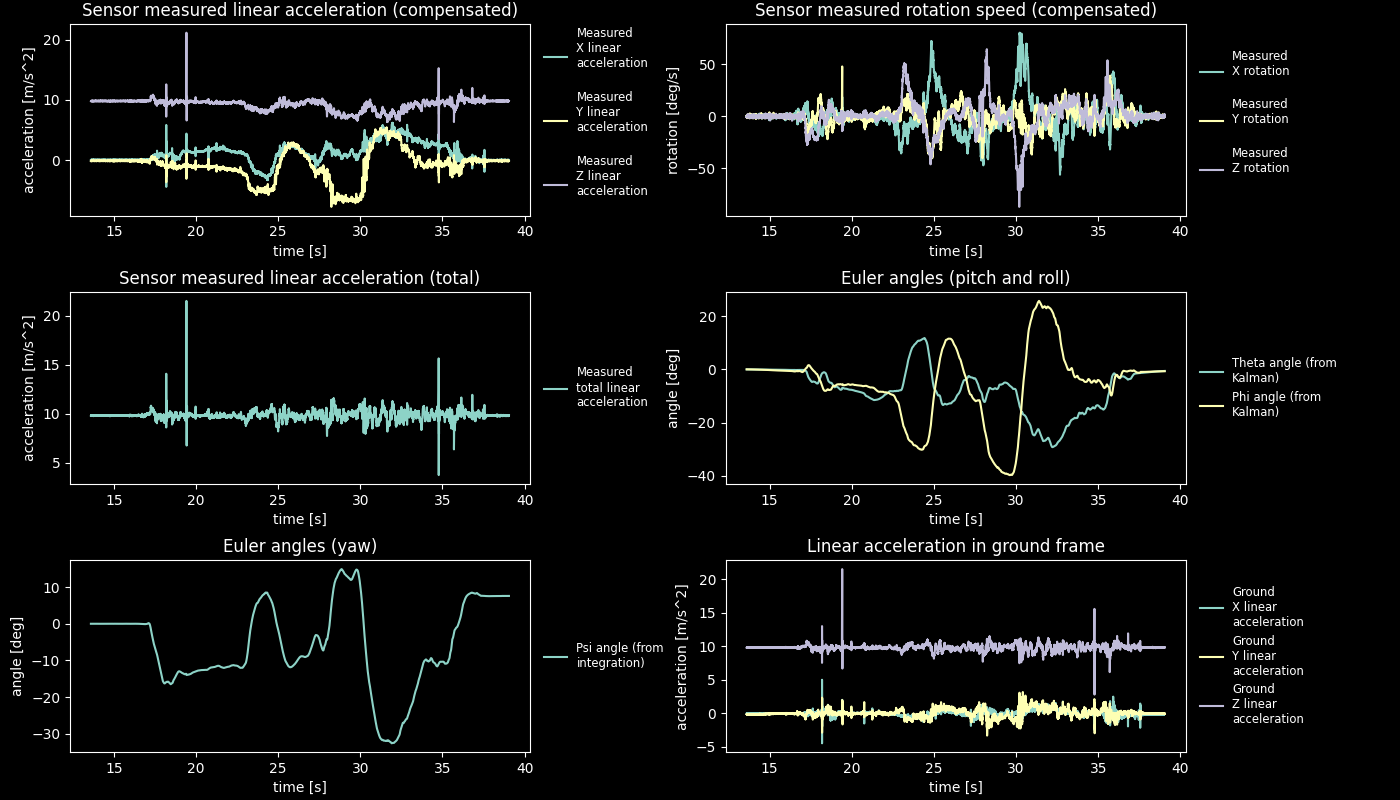

In [48]:
# Use dark theme for plots
plt.style.use('dark_background')

# Set up plot figure (canvas)
figure, axis = plt.subplots(3, 4,figsize=(14,8),gridspec_kw={'width_ratios': [2.6, 1,2.6,1]})

# First plot - Raw sensor acceleration data + bias compensation
axis[0, 0].plot(data.index, data['mean_acc_X_b'], label='Measured\nX linear\nacceleration\n')
axis[0, 0].plot(data.index, data['mean_acc_Y_b'], label='Measured\nY linear\nacceleration\n')
axis[0, 0].plot(data.index, data['mean_acc_Z_b'], label='Measured\nZ linear\nacceleration\n')
#axis[0, 0].plot(data.index, data['mean_acc_X'], label='sensor X raw')
#axis[0, 0].plot(data.index, data['mean_acc_Y'], label='sensor Y raw')
#axis[0, 0].plot(data.index, data['mean_acc_Z'], label='sensor Z raw')
axis[0, 0].set_title('Sensor measured linear acceleration (compensated)')
axis[0, 0].set_xlabel('time [s]')
axis[0, 0].set_ylabel('acceleration [m/s^2]')
# Set legend next to plot
h_0_0,l_0_0 = axis[0,0].get_legend_handles_labels()
axis[0,1].legend(h_0_0,l_0_0,borderaxespad=0, mode='expand', loc='center', fontsize='small',frameon=False)
axis[0,1].axis("tight")
axis[0,1].axis("off")



# Second plot - Gyroscope data
axis[0, 2].plot(data.index, data['mean_gyro_X_b'], label='Measured\nX rotation\n')
axis[0, 2].plot(data.index, data['mean_gyro_Y_b'], label='Measured\nY rotation\n')
axis[0, 2].plot(data.index, data['mean_gyro_Z_b'], label='Measured\nZ rotation\n')
axis[0, 2].set_title('Sensor measured rotation speed (compensated)')
axis[0, 2].set_xlabel('time [s]')
axis[0, 2].set_ylabel('rotation [deg/s]')
# Set legend next to plot
h_0_2,l_0_2 = axis[0,2].get_legend_handles_labels()
axis[0,3].legend(h_0_2,l_0_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[0,3].axis("tight")
axis[0,3].axis("off")


# Third plot - Total acceleration (for checking whwther if translations work)
axis[1, 0].plot(data.index, data['g_sensor'], label='Measured\ntotal linear\nacceleration')
#axis[1, 0].plot(data.index, data['g_ground'], label='ground acceleration')
axis[1, 0].set_title('Sensor measured linear acceleration (total)')
axis[1, 0].set_xlabel('time [s]')
axis[1, 0].set_ylabel('acceleration [m/s^2]')
# Set legend next to plot
h_1_0,l_1_0 = axis[1,0].get_legend_handles_labels()
axis[1,1].legend(h_1_0,l_1_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,1].axis("tight")
axis[1,1].axis("off")


# Fourth plot - Kalman angular input, output
axis[1, 2].plot(data.index, data['theta_hat'] * 180 / pi, label='Theta angle (from\nKalman)')
axis[1, 2].plot(data.index, data['phi_hat'] * 180 / pi, label='Phi angle (from\nKalman)')
axis[1, 2].set_title('Euler angles (pitch and roll)')
axis[1, 2].set_xlabel('time [s]')
axis[1, 2].set_ylabel('angle [deg]')
# Set legend next to plot
h_1_2,l_1_2 = axis[1,2].get_legend_handles_labels()
axis[1,3].legend(h_1_2,l_1_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,3].axis("tight")
axis[1,3].axis("off")


#Fifth plot - Phi angle from acceleration integration
axis[2, 0].plot(data.index, data['psi_hat'] * 180 / pi, label='Psi angle (from\nintegration)')
axis[2, 0].set_title('Euler angles (yaw)')
axis[2, 0].set_xlabel('time [s]')
axis[2, 0].set_ylabel('angle [deg]')
# Set legend next to plot
h_2_0,l_2_0 = axis[2,0].get_legend_handles_labels()
axis[2,1].legend(h_2_0,l_2_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,1].axis("tight")
axis[2,1].axis("off")


# Sixth plot ground frame linear acceleration
axis[2, 2].plot(data.index, data['acc_X_e'], label='Ground\nX linear\nacceleration')
axis[2, 2].plot(data.index, data['acc_Y_e'], label='Ground\nY linear\nacceleration')
# axis[2, 1].plot(data.index, data['acc_Z_e'] - 9.8159, label='ground Z')
axis[2, 2].plot(data.index, data['acc_Z_e'], label='Ground\nZ linear\nacceleration')
axis[2, 2].set_title('Linear acceleration in ground frame')
axis[2, 2].set_xlabel('time [s]')
axis[2, 2].set_ylabel('acceleration [m/s^2]')
# Set legend next to plot
h_2_2,l_2_2 = axis[2,2].get_legend_handles_labels()
axis[2,3].legend(h_2_2,l_2_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,3].axis("tight")
axis[2,3].axis("off")
figure.subplots_adjust(left=0.05,
                    bottom=0.06, 
                    right=0.98, 
                    top=0.97, 
                    wspace=0.03, 
                    hspace=0.4)
#plt.subplot_tool()
#figure.tight_layout(pad=0.1, w_pad=0, h_pad=0.01)


Text(0.5, 0, 'position Z [m]')

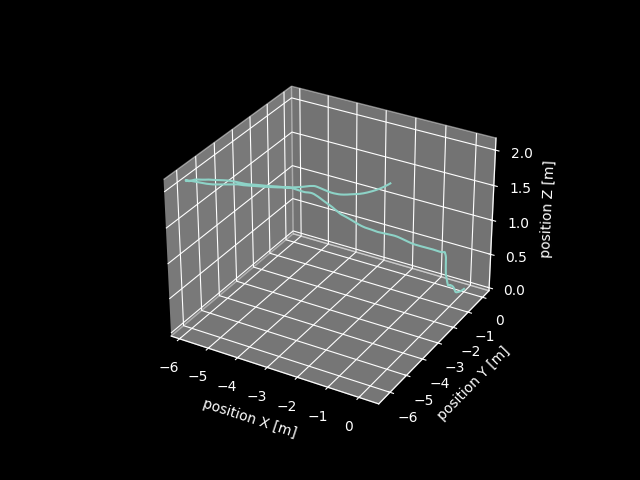

In [49]:
ax1 = plt.figure().add_subplot(projection='3d')
ax1.plot(curve.x_point_list, curve.y_point_list, curve.z_point_list, label='position curve')
ax1.set_xlabel('position X [m]')
ax1.set_ylabel('position Y [m]')
ax1.set_zlabel('position Z [m]')

Text(0.5, 0, 'speed Z [m/s]')

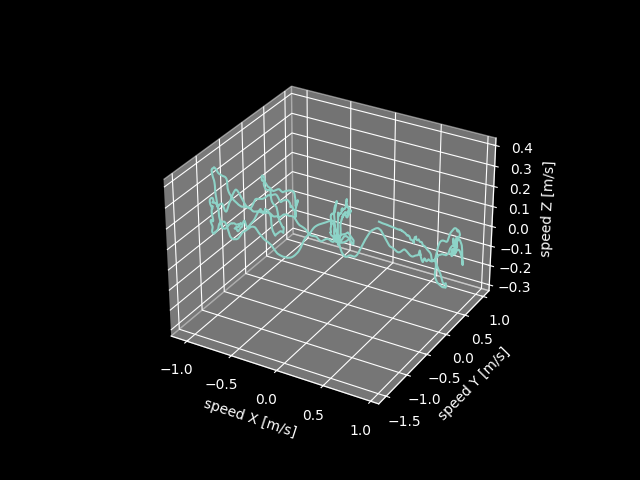

In [50]:
ax2 = plt.figure().add_subplot(projection='3d')
ax2.plot(curve.x_speed_list, curve.y_speed_list, curve.z_speed_list, label='speed curve')
ax2.set_xlabel('speed X [m/s]')
ax2.set_ylabel('speed Y [m/s]')
ax2.set_zlabel('speed Z [m/s]')
# data.to_csv('output.csv')

# print('Lack of testing code')

# Adding scanner points to path

## Get points data from database

In [51]:
data_scanner=db_client.get_scanner_data('scan_sensor_test', time_start, time_stop).dropna()

In [52]:
    with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                           'display.precision', 6,
                           ):
        print(data_scanner.describe())

             point_X       points_Z       time_rel
count  328180.000000  328180.000000  328180.000000
mean        1.490031      48.167767      22.503650
std        22.057280      22.352594       1.985438
min       -50.873047       8.432007      19.508643
25%       -15.503174      30.880737      20.712631
50%         2.137085      43.643188      22.232425
75%        18.928467      60.461426      24.349306
max        48.423218     122.982788      25.919695


In [53]:
# Set time as index
data_scanner.set_index('time_rel', inplace=True)
# Change index column name for it to be compatible with other data
data_scanner.index.names=['mean_time_rel']

### Interpolate device information for data points 

In [54]:
# Copy scanner data
index_tmp_df = data_scanner.copy()

# Leave only indexes without duplicates
index_tmp_df=index_tmp_df[~index_tmp_df.index.duplicated(keep='first')]

with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                        'display.precision', 6,
                        ):
    print(index_tmp_df.describe())

          point_X    points_Z
count  651.000000  651.000000
mean   -39.598656   72.421841
std      9.684871   28.630901
min    -50.873047   14.721680
25%    -44.953247   60.749817
50%    -41.773682   68.847656
75%    -34.997559  101.234436
max     25.622681  122.982788


In [55]:
# Drop points columns to leave only 
index_tmp_df=index_tmp_df.drop(columns=['point_X','points_Z'])

In [56]:
interpolation_df= pd.concat([index_tmp_df, data[['theta_hat','phi_hat','psi_hat']]], ignore_index=False, join='outer')
interpolation_df.sort_index(inplace=True)
interpolation_df.interpolate(inplace=True)

In [57]:
index_tmp_df.index

Float64Index([ 19.50864315032959, 19.519514083862305,  19.52125597000122,
              19.522505044937134, 19.523771047592163, 19.525057077407837,
              19.526307106018066,  19.52762508392334,   19.5294930934906,
              19.530987977981567,
              ...
              25.830069065093994, 25.839250087738037, 25.849568128585815,
              25.859391927719116, 25.869372129440308, 25.879420042037964,
               25.88944697380066, 25.899425983428955, 25.909470081329346,
              25.919695138931274],
             dtype='float64', name='mean_time_rel', length=651)

In [58]:
interpolated_angles = interpolation_df.loc[index_tmp_df.index.values]

## Rotate scanner points vectors to device default frame

In [59]:
# Go from scanner frame coordinates, to device coordinates
data_scanner_dev_frame = pd.DataFrame()
data_scanner_dev_frame['Z']=-data_scanner['points_Z']
data_scanner_dev_frame['Y']=-data_scanner['point_X']
data_scanner_dev_frame['X']=0.0
# Add device euler angles
data_scanner_dev_frame = pd.concat([data_scanner_dev_frame,interpolated_angles], axis = 1)

with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(data_scanner_dev_frame.head())

                    Z       Y    X  theta_hat  phi_hat  psi_hat
mean_time_rel                                                  
19.509        -62.961  41.588  0.0     -0.123   -0.105   -0.242
19.509        -62.961  41.461  0.0     -0.123   -0.105   -0.242
19.509        -62.952  41.327  0.0     -0.123   -0.105   -0.242
19.509        -62.915  41.193  0.0     -0.123   -0.105   -0.242
19.509        -62.915  41.066  0.0     -0.123   -0.105   -0.242


In [60]:
# Rotate point vectors with device euler angles in order to get global point translation vectors
points_translation = translator.rotate_vect(data_scanner_dev_frame)


df_copied


In [61]:
print( points_translation)

                     X_e        Y_e        Z_e
mean_time_rel                                 
19.508643      16.336865  31.787294 -66.454956
19.508643      16.305086  31.665467 -66.441824
19.508643      16.270580  31.537671 -66.418883
19.508643      16.233502  31.413469 -66.368834
19.508643      16.201723  31.291641 -66.355702
...                  ...        ...        ...
25.919695      10.481467 -30.922721 -71.794034
25.919695      10.443656 -31.030532 -71.725480
25.919695      10.415370 -31.171843 -71.726856
25.919695      10.392851 -31.303138 -71.744268
25.919695      10.359920 -31.447249 -71.728154

[328180 rows x 3 columns]


## calculate points position in earth frame

In [62]:
# interpolate positions from curve

int_curve_df= pd.concat([index_tmp_df, curve_df], ignore_index=False, join='outer')
int_curve_df.sort_index(inplace=True)
int_curve_df.interpolate(inplace=True)
int_curve_df.head()

,X_p_e,Y_p_e,Z_p_e
mean_time_rel,,,
13.605351,0.000000e+00,0.000000e+00,0.000000e+00
13.606430,9.016911e-09,-7.354532e-08,5.127171e-09
13.607377,3.242959e-08,-2.560089e-07,2.438827e-08
13.608353,7.266463e-08,-5.565321e-07,5.907037e-08
13.609340,1.314095e-07,-9.775091e-07,9.228492e-08


In [63]:
interpolated_curve = int_curve_df.loc[index_tmp_df.index.values]
interpolated_curve.describe()

,X_p_e,Y_p_e,Z_p_e
count,651.000000,651.000000,651.000000
mean,-0.207585,-1.932086,0.863460
std,0.509997,0.705282,0.326010
min,-1.683455,-3.602770,0.296990
25%,-0.270338,-2.278305,0.597296
50%,-0.002119,-1.753382,0.902725
75%,0.115095,-1.386998,1.067766
max,0.189453,-1.094323,1.479906


In [69]:
interpolated_curve.head()

,X_p_e,Y_p_e,Z_p_e
mean_time_rel,,,
19.508643,-0.023836,-1.094323,0.296990
19.519514,-0.023940,-1.096424,0.298788
19.521256,-0.023949,-1.096623,0.298961
19.522505,-0.023964,-1.096974,0.299265
19.523771,-0.023972,-1.097169,0.299434


### Calculate final points on curve

In [64]:
vects_and_curve = pd.concat([interpolated_curve,points_translation], axis = 1)
vects_and_curve.head()

,X_p_e,Y_p_e,Z_p_e,X_e,Y_e,Z_e
mean_time_rel,,,,,,
19.508643,-0.023836,-1.094323,0.29699,16.336865,31.787294,-66.454956
19.508643,-0.023836,-1.094323,0.29699,16.305086,31.665467,-66.441824
19.508643,-0.023836,-1.094323,0.29699,16.270580,31.537671,-66.418883
19.508643,-0.023836,-1.094323,0.29699,16.233502,31.413469,-66.368834
19.508643,-0.023836,-1.094323,0.29699,16.201723,31.291641,-66.355702


In [65]:
final_points = pd.DataFrame()
final_points['X'] = vects_and_curve['X_p_e']+vects_and_curve['X_e']/1000
final_points['Y'] = vects_and_curve['Y_p_e']+vects_and_curve['Y_e']/1000
final_points['Z'] = vects_and_curve['Z_p_e']+vects_and_curve['Z_e']/1000


Text(0.5, 0, 'position Z [m]')

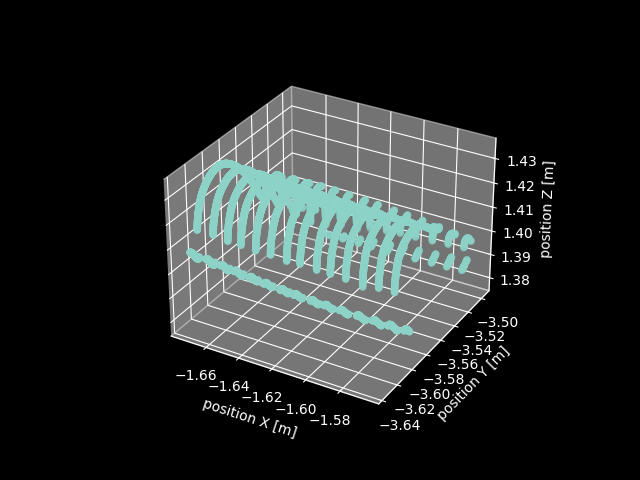

In [66]:
ax3 = plt.figure().add_subplot(projection='3d')
ax3.scatter(final_points.tail(8000)['X'], final_points.tail(8000)['Y'], final_points.tail(8000)['Z'], label='points')
#ax3.set_xlim([-0.1,0.1])
#ax3.set_ylim([-2,-1])
#ax3.set_zlim([0.3,0.5])
ax3.set_xlabel('position X [m]')
ax3.set_ylabel('position Y [m]')
ax3.set_zlabel('position Z [m]')

### Reorganize data to make it usable in optimizer


In [84]:
# Input structure for device curve
#       input_structure = [{'mean_time_rel': 0.0,
#                          'dev_pos': {'X': 0.0, 'Y': 0.0, 'Z': 0.0},
#                          'dev_rot_vect': {'X': 0.0, 'Y': 0.0, 'Z': 0.0},
#                          'scanner_points': [{'X': 0.0, 'Y': 0.0, 'Z': 0.0}]}]
#                          scanner points must be in device frame as it won't change
from scipy.spatial.transform import Rotation


positions = []
for index in index_tmp_df.index:
    # 'mean_time_rel': 0.0,
    mean_time_rel_in = index
    
    # 'dev_pos': {'X': 0.0, 'Y': 0.0, 'Z': 0.0}
    pos_row = interpolated_curve.loc[index]
    dev_pos_in = {'X':pos_row['X_p_e'],'Y':pos_row['Y_p_e'],'Z':pos_row['Z_p_e']}
    
    # 'dev_rot_vect': {'X': 0.0, 'Y': 0.0, 'Z': 0.0}
    rot_row = interpolated_angles.loc[index]
    ang_names = ['psi_hat', 'theta_hat', 'phi_hat']
    rot = Rotation.from_euler('ZYX', [rot_row[ang_names[0]], rot_row[ang_names[1]], rot_row[ang_names[2]]], degrees=False)
    rot_vect = rot.as_rotvec()
    dev_rot_in = {'X':rot_vect[0],'Y':rot_vect[1],'Z':rot_vect[2]}
    
    # 'scanner_points': [{'X': 0.0, 'Y': 0.0, 'Z': 0.0}]
    scanner_points_in = []
    for point in data_scanner_dev_frame.loc[index].iterrows():
        scanner_points_in.append({'X': point[1]['X']/1000, 'Y': point[1]['Y']/1000, 'Z': point[1]['Z']/1000})
        
    # input_structure list filling
    positions.append({'mean_time_rel': index,
                      'dev_pos': dev_pos_in,
                      'dev_rot_vect': dev_rot_in,
                      'scanner_points': scanner_points_in.copy()})

import json
with open('/media/adamw/DATA/Projekty/Praca_mgr/scan_3d_MGR/gui_server/DataAnalysisClasses/test.json', 'w') as fout:
    json.dump(positions , fout)
